In [1]:
import networkx as nx

In [2]:
import matplotlib

In [3]:
H = nx.DiGraph()
H.add_nodes_from([
  (0, {"color": "gray", "size": 450}),
  (1, {"color": "yellow", "size": 700}),
  (2, {"color": "red", "size": 250}),
  (3, {"color": "pink", "size": 500})
])
for node in H.nodes(data=True):
  print(node)


(0, {'color': 'gray', 'size': 450})
(1, {'color': 'yellow', 'size': 700})
(2, {'color': 'red', 'size': 250})
(3, {'color': 'pink', 'size': 500})


In [4]:
H.add_edges_from([
  (0, 1),
  (1, 2),
  (2, 0),
  (2, 3),
  (3, 2)
])
print(H.edges())

[(0, 1), (1, 2), (2, 0), (2, 3), (3, 2)]


In [5]:
def print_graph_info(graph):
  print("Directed graph:", graph.is_directed())
  print("Number of nodes:", graph.number_of_nodes())
  print("Number of edges:", graph.number_of_edges())
print_graph_info(H)

Directed graph: True
Number of nodes: 4
Number of edges: 5



Bad key text.latex.unicode in file /dartfs-hpc/rc/home/d/f0036rd/.conda/envs/SHAPenv/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 112 ('text.latex.unicode : False # use "ucs" and "inputenc" LaTeX packages for handling')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.1/matplotlibrc.template
or from the matplotlib source distribution

Bad key text.latex.preview in file /dartfs-hpc/rc/home/d/f0036rd/.conda/envs/SHAPenv/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 125 ('text.latex.preview : False')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.1/matplotlibrc.template
or from the matplotlib source distribution

Bad key mathtext.fallback_to_cm in file /dartfs-hpc/rc/home/d/f0036rd/.conda/envs/SHAPenv/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 

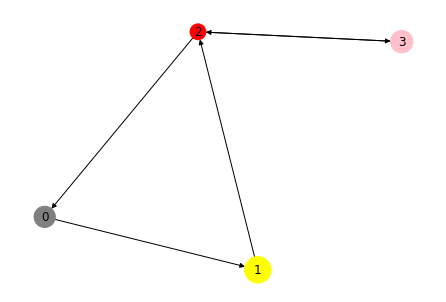

In [6]:
node_colors = nx.get_node_attributes(H, "color").values()
colors = list(node_colors)

node_sizes = nx.get_node_attributes(H, "size").values()
sizes = list(node_sizes)

nx.draw(H, with_labels=True, node_color=colors, node_size=sizes)

# Tooling around with the NN

In [7]:
import torch

KeyboardInterrupt: 

In [8]:
import os
#print(os.environ)
import torch_geometric.datasets
from torch_geometric.datasets import KarateClub

dataset = KarateClub()
print("Dataset:", dataset)
print("# Graphs:", len(dataset))
print("# Features:", dataset.num_features)
print("# Classes:", dataset.num_classes)

NameError: name '_C' is not defined

In [ ]:
conda install cudatoolkit=7.5.0

# Tooling Around Part 2


In [1]:
import os
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score

class ShapNN(object):
    
    def __init__(self, mode, hidden_units=[100], learning_rate=0.001, 
                 dropout = 0., activation=None, initializer=None,
                 weight_decay=0.0001, optimizer='adam', batch_size=128,
                 warm_start=False, max_epochs=100, validation_fraction=0.1,
                 early_stopping=0, address=None, test_batch_size=1000,
                 random_seed=666):
        
        self.mode = mode
        self.batch_size = batch_size
        self.test_batch_size = test_batch_size
        self.hidden_units = hidden_units
        self.initializer = initializer
        self.activation = activation
        self.dropout = dropout
        self.weight_decay = weight_decay
        self.optimizer = optimizer
        self.learning_rate = learning_rate
        self.warm_start = warm_start
        self.max_epochs = max_epochs
        self.early_stopping = early_stopping
        self.validation_fraction = validation_fraction
        self.address = address
        self._extra_train_ops = []
        self.random_seed = random_seed
        self.is_built = False

    def prediction_cost(self, X_test, y_test, batch_size=None):
        
        if batch_size is None:
            batch_size = self.test_batch_size
        assert len(set(y_test)) == self.num_classes, 'Number of classes does not match!'
        with self.graph.as_default():
            losses = []
            idxs = np.arange(len(X_test))            
            batches = [idxs[k * batch_size: (k+1) * batch_size] 
                       for k in range(int(np.ceil(len(idxs)/batch_size)))]
            for batch in batches:
                losses.append(self.sess.run(self.prediction_loss, {self.input_ph:X_test[batch],
                                                                   self.labels:y_test[batch]}))
            return np.mean(losses)     
        
    def score(self, X_test, y_test, batch_size=None):
        
        if batch_size is None:
            batch_size = self.test_batch_size
        assert len(set(y_test)) == self.num_classes, 'Number of classes does not match!'
        with self.graph.as_default():
            scores = []
            idxs = np.arange(len(X_test))     
            batches = [idxs[k * batch_size: (k+1) * batch_size] 
                       for k in range(int(np.ceil(len(idxs)/batch_size)))]
            for batch in batches:
                scores.append(self.sess.run(self.prediction_score, {self.input_ph:X_test[batch],
                                                                   self.labels:y_test[batch]}))
            return np.mean(scores)
        
    def predict_proba(self, X_test, batch_size=None):
        
        if batch_size is None:
            batch_size = self.test_batch_size
        with self.graph.as_default():
            probs = []
            idxs = np.arange(len(X_test))     
            batches = [idxs[k * batch_size: (k+1) * batch_size] 
                       for k in range(int(np.ceil(len(idxs)/batch_size)))]
            for batch in batches:
                probs.append(self.sess.run(self.probs, {self.input_ph:X_test[batch]}))
            return np.concatenate(probs, axis=0)    
        
    def predict_log_proba(self, X_test, batch_size=None):
        
        if batch_size is None:
            batch_size = self.test_batch_size
        with self.graph.as_default():
            probs = []
            idxs = np.arange(len(X_test))            
            batches = [idxs[k * batch_size: (k+1) * batch_size] 
                       for k in range(int(np.ceil(len(idxs)/batch_size)))]
            for batch in batches:
                probs.append(self.sess.run(self.probs, {self.input_ph:X_test[batch]}))
            return np.log(np.clip(np.concatenate(probs), 1e-12, None))   
        
    def cost(self, X_test, y_test, batch_size=None):
        
        if batch_size is None:
            batch_size = self.batch_size
        with self.graph.as_default():
            losss = []
            idxs = np.arange(len(X_test))            
            batches = [idxs[k * batch_size: (k+1) * batch_size] 
                       for k in range(int(np.ceil(len(idxs)/batch_size)))]
            for batch in batches:
                losss.append(self.sess.run(self.prediction_loss, {self.input_ph:X_test[batch],
                                                                   self.labels:y_test[batch]}))
            return np.mean(losss)
    
    def predict(self, X_test, batch_size=None):
        
        if batch_size is None:
            batch_size = self.batch_size
        with self.graph.as_default():
            predictions = []
            idxs = np.arange(len(X_test))
            batches = [idxs[k * batch_size: (k+1) * batch_size] 
                       for k in range(int(np.ceil(len(idxs)/batch_size)))]
            for batch in batches:
                predictions.append(self.sess.run(self.predictions, {self.input_ph:X_test[batch]}))
            return np.concatenate(predictions)
        
    def fit(self, X, y, X_val=None, y_val=None, sources=None, max_epochs=None,
            batch_size=None, save=False, load=False, sample_weight=None,
            metric='accuracy'):
        
        self.num_classes = len(set(y))
        self.metric = metric
        if max_epochs is None:
            max_epochs = self.max_epochs
        if batch_size is None:
            batch_size = self.batch_size
        if not self.is_built:
            self.graph = tf.Graph() 
            with self.graph.as_default():
                config = tf.ConfigProto()
                config.gpu_options.allow_growth=True
                self.sess = tf.Session(config=config)
        with self.graph.as_default():
            tf.set_random_seed(self.random_seed)
            try:
                self.global_step = tf.train.create_global_step()
            except ValueError:
                self.global_step = tf.train.get_global_step()
            if not self.is_built:
                self._build_model(X, y)
                self.saver = tf.train.Saver()
            self._initialize()
            if len(X):
                if X_val is None and self.validation_fraction * len(X) > 2:
                    X_train, X_val, y_train, y_val, sample_weight, _ = train_test_split(
                        X, y, sample_weight, test_size=self.validation_fraction)
                else:
                    X_train, y_train = X, y
                self._train_model(X_train, y_train, X_val=X_val, y_val=y_val,
                                  max_epochs=max_epochs, batch_size=batch_size,
                                  sources=sources, sample_weight=sample_weight)
                if save and self.address is not None:
                    self.saver.save(self.sess, self.address)
            
    def _train_model(self, X, y, X_val, y_val, max_epochs, batch_size, 
                     sources=None, sample_weight=None):
        
        
        assert len(X)==len(y), 'Input and labels not the same size'
        self.history = {'metrics':[], 'idxs':[]}
        stop_counter = 0
        best_performance = None
        for epoch in range(max_epochs):
            vals_metrics, idxs = self._one_epoch(
                X, y, X_val, y_val, batch_size, sources=sources, sample_weight=sample_weight)
            self.history['idxs'].append(idxs)
            self.history['metrics'].append(vals_metrics)
            if self.early_stopping and X_val is not None:
                current_performance = np.mean(val_acc)
                if best_performance is None:
                    best_performance = current_performance
                if current_performance > best_performance:
                    best_performance = current_performance
                    stop_counter = 0
                else:
                    stop_counter += 1
                    if stop_counter > self.early_stopping:
                        break
        
    def _one_epoch(self, X, y, X_val, y_val, batch_size, sources=None, sample_weight=None):
        
        vals = []
        if sources is None:
            if sample_weight is None:
                idxs = np.random.permutation(len(X))
            else:
                idxs = np.random.choice(len(X), len(X), p=sample_weight/np.sum(sample_weight))    
            batches = [idxs[k*batch_size:(k+1) * batch_size]
                       for k in range(int(np.ceil(len(idxs)/batch_size)))]
            idxs = batches
        else:
            idxs = np.random.permutation(len(sources.keys()))
            batches = [sources[i] for i in idxs]
        for batch_counter, batch in enumerate(batches):
            self.sess.run(self.train_op, 
                          {self.input_ph:X[batch], self.labels:y[batch],
                           self.dropout_ph:self.dropout})
            if X_val is not None:
                if self.metric=='accuracy':
                    vals.append(self.score(X_val, y_val))
                elif self.metric=='f1':
                    vals.append(f1_score(y_val, self.predict(X_val)))
                elif self.metric=='auc':
                    vals.append(roc_auc_score(y_val, self.predict_proba(X_val)[:,1]))
                elif self.metric=='xe':
                    vals.append(-self.prediction_cost(X_val, y_val))
        return np.array(vals), np.array(idxs)
    
    def _initialize(self):
        
        uninitialized_vars = []
        if self.warm_start:
            for var in tf.global_variables():
                try:
                    self.sess.run(var)
                except tf.errors.FailedPreconditionError:
                    uninitialized_vars.append(var)
        else:
            uninitialized_vars = tf.global_variables()
        self.sess.run(tf.initializers.variables(uninitialized_vars))
        
    def _build_model(self, X, y):
        
        self.num_classes = len(set(y))
        if self.initializer is None:
            initializer = tf.initializers.variance_scaling(distribution='uniform')
        if self.activation is None:
            activation = lambda x: tf.nn.relu(x)
        self.input_ph = tf.placeholder(dtype=tf.float32, shape=(None,) + X.shape[1:], name='input')
        self.dropout_ph = tf.placeholder_with_default(
            tf.constant(0., dtype=tf.float32), shape=(), name='dropout')
        if self.mode=='regression':
            self.labels = tf.placeholder(dtype=tf.float32, shape=(None, ), name='label')
        else:
            self.labels = tf.placeholder(dtype=tf.int32, shape=(None, ), name='label')
        x = tf.reshape(self.input_ph, shape=(-1, np.prod(X.shape[1:])))
        for layer, hidden_unit in enumerate(self.hidden_units):
            with tf.variable_scope('dense_{}'.format(layer)):
                x = self._dense(x, hidden_unit, dropout=self.dropout_ph, 
                           initializer=self.initializer, activation=activation)
        with tf.variable_scope('final'):
            self.prelogits = x
            self._final_layer(self.prelogits, self.num_classes, self.mode)
        self._build_train_op()
        
    def _build_train_op(self):
        
        """Build taining specific ops for the graph."""
        learning_rate = tf.constant(self.learning_rate, tf.float32) ##fixit
        trainable_variables = tf.trainable_variables()
        grads = tf.gradients(self.loss, trainable_variables)
        self.grad_flat = tf.concat([tf.reshape(grad, (-1, 1)) for grad in grads], axis=0)
        if self.optimizer == 'sgd':
            optimizer = tf.train.GradientDescentOptimizer(learning_rate)
        elif self.optimizer == 'mom':
            optimizer = tf.train.MomentumOptimizer(learning_rate, 0.9)
        elif self.optimizer == 'adam':
            optimizer = tf.train.AdamOptimizer(learning_rate)
        apply_op = optimizer.apply_gradients(
            zip(grads, trainable_variables),
            global_step=self.global_step, name='train_step')
        train_ops = [apply_op] + self._extra_train_ops + tf.get_collection(tf.GraphKeys.UPDATE_OPS)
        previous_ops = [tf.group(*train_ops)]
        with tf.control_dependencies(previous_ops):
            self.train_op = tf.no_op(name='train')   
        self.is_built = True
    
    def _final_layer(self, x, num_classes, mode):
        
        if mode=='regression':
            self.logits = self._dense(x, 1, dropout=self.dropout_ph)
            self.predictions = tf.reduce_sum(self.logits, axis=-1)
            regression_loss = tf.nn.l2_loss(self.predictions - self.labels) ##FIXIT
            self.prediction_loss = tf.reduce_mean(regression_loss, name='l2')
            residuals = self.predictions - self.labels
            var_predicted = tf.reduce_mean(residuals**2) - tf.reduce_mean(residuals)**2
            var_labels = tf.reduce_mean(self.labels**2) - tf.reduce_mean(self.labels)**2
            self.prediction_score = 1 - var_predicted/(var_labels + 1e-12)
        else:
            self.logits = self._dense(x, num_classes, dropout=self.dropout_ph)
            self.probs = tf.nn.softmax(self.logits)
            xent_loss = tf.nn.sparse_softmax_cross_entropy_with_logits(
                logits=self.logits, labels=tf.cast(self.labels, tf.int32))
            self.prediction_loss = tf.reduce_mean(xent_loss, name='xent')
            self.predictions = tf.argmax(self.probs, axis=-1, output_type=tf.int32)
            correct_predictions = tf.equal(self.predictions, self.labels)
            self.prediction_score = tf.reduce_mean(tf.cast(correct_predictions, tf.float32))
        self.loss = self.prediction_loss + self._reg_loss()
                
    def _dense(self, x, out_dim, dropout=tf.constant(0.), initializer=None, activation=None):
        
        if initializer is None:
            initializer = tf.initializers.variance_scaling(distribution='uniform')
        w = tf.get_variable('DW', [x.get_shape()[1], out_dim], initializer=initializer)
        b = tf.get_variable('Db', [out_dim], initializer=tf.constant_initializer())
        x = tf.nn.dropout(x, 1. - dropout)
        if activation:
            x = activation(x)
        return tf.nn.xw_plus_b(x, w, b)
    
    def _reg_loss(self, order=2):
        """Regularization loss for weight decay."""
        losss = []
        for var in tf.trainable_variables():
            if var.op.name.find(r'DW') > 0 or var.op.name.find(r'CW') > 0: ##FIXIT
                if order==2:
                    losss.append(tf.nn.l2_loss(var))
                elif order==1:
                    losss.append(tf.abs(var))
                else:
                    raise ValueError("Invalid regularization order!")
        return tf.multiply(self.weight_decay, tf.add_n(losss))


class CShapNN(ShapNN):
    
    def __init__(self, mode, hidden_units=[100], kernel_sizes=[], 
                 strides=None, channels=[], learning_rate=0.001, 
                 dropout = 0., activation=None, initializer=None, global_averaging=False,
                weight_decay=0.0001, optimizer='adam', batch_size=128, 
                warm_start=False, max_epochs=100, validation_fraction=0.1,
                early_stopping=0, address=None, test_batch_size=1000, random_seed=666):
        
        self.mode = mode
        self.test_batch_size = test_batch_size
        self.kernels = []#FIXIT
        self.kernel_sizes = kernel_sizes
        self.channels = channels
        self.global_averaging = global_averaging
        assert len(channels)==len(kernel_sizes), 'Invalid channels or kernel_sizes'
        if strides is None:
            self.strides = [1] * len(kernel_sizes)
        else:
            self.strides = strides
        self.batch_size = batch_size
        self.hidden_units = hidden_units
        self.initializer = initializer
        self.activation = activation
        self.dropout = dropout
        self.weight_decay = weight_decay
        self.optimizer = optimizer
        self.learning_rate = learning_rate
        self.warm_start = warm_start
        self.max_epochs = max_epochs
        self.early_stopping = early_stopping
        self.validation_fraction = validation_fraction
        self.address = address
        self._extra_train_ops = []
        self.random_seed = random_seed
        self.graph = tf.Graph()
        self.is_built = False
        with self.graph.as_default():
            config = tf.ConfigProto()
            config.gpu_options.allow_growth=True
            self.sess = tf.Session(config=config)
            
    def _conv(self, x, filter_size, out_filters, strides, activation=None):
        
        in_filters = int(x.get_shape()[-1])
        n = filter_size * filter_size * out_filters
        kernel = tf.get_variable(
            'DW', [filter_size, filter_size, in_filters, out_filters],
            tf.float32, initializer=tf.random_normal_initializer(
                stddev=np.sqrt(2.0/n)))
        self.kernels.append(kernel)
        x = tf.nn.conv2d(x, kernel, strides, padding='SAME')
        if activation:
            x = activation(x)
        return x
    
    def _stride_arr(self, stride):
        
        if isinstance(stride, int):
            return [1, stride, stride, 1]
        if len(stride)==2:
            return [1, stride[0], stride[1], 1]
        if len(stride)==4:
            return stride
        raise ValueError('Invalid value!')  
        
    def _build_model(self, X, y):
        
        
        if self.initializer is None:
            initializer = tf.initializers.variance_scaling(distribution='uniform')
        if self.activation is None:
            activation = lambda x: tf.nn.relu(x)
        self.input_ph = tf.placeholder(dtype=tf.float32, shape=(None,) + X.shape[1:], name='input')
        self.dropout_ph = tf.placeholder_with_default(
            tf.constant(0., dtype=tf.float32), shape=(), name='dropout')
        if self.mode=='regression':
            self.labels = tf.placeholder(dtype=tf.float32, shape=(None, ), name='label')
        else:
            self.labels = tf.placeholder(dtype=tf.int32, shape=(None, ), name='label')
        if len(X.shape[1:]) == 2:
            x = tf.reshape(self.input_ph, [-1, X.shape[0], X.shape[1], 1])
        else:
            x = self.input_ph
        for layer, (kernel_size, channels, stride) in enumerate(zip(
            self.kernel_sizes, self.channels, self.strides)):
            with tf.variable_scope('conv_{}'.format(layer)):
                x = self._conv(x, kernel_size, channels, self._stride_arr(stride), activation=activation)
        if self.global_averaging:
            x = tf.reduce_mean(x, axis=(1,2))
        else:
            x = tf.reshape(x, shape=(-1, np.prod(x.get_shape()[1:])))
        for layer, hidden_unit in enumerate(self.hidden_units):
            with tf.variable_scope('dense_{}'.format(layer)):
                x = self._dense(x, hidden_unit, dropout=self.dropout_ph, 
                           initializer=self.initializer, activation=activation)
                
        with tf.variable_scope('final'):
            self.prelogits = x
            self._final_layer(self.prelogits, len(set(y)), self.mode)
        self._build_train_op()


/dartfs-hpc/rc/home/d/f0036rd/.conda/envs/SHAPenv/lib/python3.7/site-packages/requests/__init__.py:104: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.0.0)/charset_normalizer (2.0.4) doesn't match a supported version!
  RequestsDependencyWarning)
2022-07-08 09:33:54.251709: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-07-08 09:33:54.252891: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-08 09:33:54.258537: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [2]:
import os
import sys
import numpy as np
import inspect
from scipy.stats import logistic
from scipy.stats import spearmanr
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import r2_score
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.base import clone
import inspect
#from Shapley import ShapNN, CShapNN
from multiprocessing import dummy as multiprocessing
from sklearn.metrics import roc_auc_score, f1_score
import warnings
import tensorflow as tf
import matplotlib.pyplot as plt
        
def convergence_plots(marginals):
    
    plt.rcParams['figure.figsize'] = 15,15
    for i, idx in enumerate(np.arange(min(25, marginals.shape[-1]))):
        plt.subplot(5,5,i+1)
        plt.plot(np.cumsum(marginals[:, idx])/np.arange(1, len(marginals)+1))    
        
    
def is_integer(array):
    return (np.equal(np.mod(array, 1), 0).mean()==1)


def is_fitted(model):
        """Checks if model object has any attributes ending with an underscore"""
        return 0 < len( [k for k,v in inspect.getmembers(model) if k.endswith('_') and not k.startswith('__')] )


def return_model(mode, **kwargs):
    
    
    if inspect.isclass(mode):
        assert getattr(mode, 'fit', None) is not None, 'Custom model family should have a fit() method'
        model = mode(**kwargs)
    elif mode=='logistic':
        solver = kwargs.get('solver', 'liblinear')
        n_jobs = kwargs.get('n_jobs', None)
        max_iter = kwargs.get('max_iter', 5000)
        model = LogisticRegression(solver=solver, n_jobs=n_jobs, 
                                 max_iter=max_iter, random_state=666)
    elif mode=='Tree':
        model = DecisionTreeClassifier(random_state=666)
    elif mode=='RandomForest':
        n_estimators = kwargs.get('n_estimators', 50)
        model = RandomForestClassifier(n_estimators=n_estimators, random_state=666)
    elif mode=='GB':
        n_estimators = kwargs.get('n_estimators', 50)
        model = GradientBoostingClassifier(n_estimators=n_estimators, random_state=666)
    elif mode=='AdaBoost':
        n_estimators = kwargs.get('n_estimators', 50)
        model = AdaBoostClassifier(n_estimators=n_estimators, random_state=666)
    elif mode=='SVC':
        kernel = kwargs.get('kernel', 'rbf')
        model = SVC(kernel=kernel, random_state=666)
    elif mode=='LinearSVC':
        model = LinearSVC(loss='hinge', random_state=666)
    elif mode=='GP':
        model = GaussianProcessClassifier(random_state=666)
    elif mode=='KNN':
        n_neighbors = kwargs.get('n_neighbors', 5)
        model = KNeighborsClassifier(n_neighbors=n_neighbors)
    elif mode=='NB':
        model = MultinomialNB()
    elif mode=='linear':
        model = LinearRegression(random_state=666)
    elif mode=='ridge':
        alpha = kwargs.get('alpha', 1.0)
        model = Ridge(alpha=alpha, random_state=666)
    elif 'conv' in mode:
        tf.reset_default_graph()
        address = kwargs.get('address', 'weights/conv')
        hidden_units = kwargs.get('hidden_layer_sizes', [20])
        activation = kwargs.get('activation', 'relu')
        weight_decay = kwargs.get('weight_decay', 1e-4)
        learning_rate = kwargs.get('learning_rate', 0.001)
        max_iter = kwargs.get('max_iter', 1000)
        early_stopping= kwargs.get('early_stopping', 10)
        warm_start = kwargs.get('warm_start', False)
        batch_size = kwargs.get('batch_size', 256)
        kernel_sizes = kwargs.get('kernel_sizes', [5])
        strides = kwargs.get('strides', [5])
        channels = kwargs.get('channels', [1])
        validation_fraction = kwargs.get('validation_fraction', 0.)
        global_averaging = kwargs.get('global_averaging', 0.)
        optimizer = kwargs.get('optimizer', 'sgd')
        if mode=='conv':
            model = CShapNN(mode='classification', batch_size=batch_size, max_epochs=max_iter,
                          learning_rate=learning_rate, 
                          weight_decay=weight_decay, validation_fraction=validation_fraction,
                          early_stopping=early_stopping,
                         optimizer=optimizer, warm_start=warm_start, address=address,
                          hidden_units=hidden_units,
                          strides=strides, global_averaging=global_averaging,
                         kernel_sizes=kernel_sizes, channels=channels, random_seed=666)
        elif mode=='conv_reg':
            model = CShapNN(mode='regression', batch_size=batch_size, max_epochs=max_iter,
                          learning_rate=learning_rate, 
                          weight_decay=weight_decay, validation_fraction=validation_fraction,
                          early_stopping=early_stopping,
                         optimizer=optimizer, warm_start=warm_start, address=address,
                          hidden_units=hidden_units,
                          strides=strides, global_averaging=global_averaging,
                         kernel_sizes=kernel_sizes, channels=channels, random_seed=666)
    elif 'NN' in mode:
        solver = kwargs.get('solver', 'adam')
        hidden_layer_sizes = kwargs.get('hidden_layer_sizes', (20,))
        if isinstance(hidden_layer_sizes, list):
            hidden_layer_sizes = list(hidden_layer_sizes)
        activation = kwargs.get('activation', 'relu')
        learning_rate_init = kwargs.get('learning_rate', 0.001)
        max_iter = kwargs.get('max_iter', 5000)
        early_stopping= kwargs.get('early_stopping', False)
        warm_start = kwargs.get('warm_start', False)
        if mode=='NN':
            model = MLPClassifier(solver=solver, hidden_layer_sizes=hidden_layer_sizes,
                                activation=activation, learning_rate_init=learning_rate_init,
                                warm_start = warm_start, max_iter=max_iter,
                                early_stopping=early_stopping)
        if mode=='NN_reg':
            model = MLPRegressor(solver=solver, hidden_layer_sizes=hidden_layer_sizes,
                                activation=activation, learning_rate_init=learning_rate_init,
                                warm_start = warm_start, max_iter=max_iter, early_stopping=early_stopping)
    else:
        raise ValueError("Invalid mode!")
    return model



def generate_features(latent, dependency):

    features = []
    n = latent.shape[0]
    exp = latent
    holder = latent
    for order in range(1,dependency+1):
        features.append(np.reshape(holder,[n,-1]))
        exp = np.expand_dims(exp,-1)
        holder = exp * np.expand_dims(holder,1)
    return np.concatenate(features,axis=-1)  


def label_generator(problem, X, param, difficulty=1, beta=None, important=None):
        
    if important is None or important > X.shape[-1]:
        important = X.shape[-1]
    dim_latent = sum([important**i for i in range(1, difficulty+1)])
    if beta is None:
        beta = np.random.normal(size=[1, dim_latent])
    important_dims = np.random.choice(X.shape[-1], important, replace=False)
    funct_init = lambda inp: np.sum(beta * generate_features(inp[:,important_dims], difficulty), -1)
    batch_size = max(100, min(len(X), 10000000//dim_latent))
    y_true = np.zeros(len(X))
    while True:
        try:
            for itr in range(int(np.ceil(len(X)/batch_size))):
                y_true[itr * batch_size: (itr+1) * batch_size] = funct_init(
                    X[itr * batch_size: (itr+1) * batch_size])
            break
        except MemoryError:
            batch_size = batch_size//2
    mean, std = np.mean(y_true), np.std(y_true)
    funct = lambda x: (np.sum(beta * generate_features(
        x[:, important_dims], difficulty), -1) - mean) / std
    y_true = (y_true - mean)/std
    if problem is 'classification':
        y_true = logistic.cdf(param * y_true)
        y = (np.random.random(X.shape[0]) < y_true).astype(int)
    elif problem is 'regression':
        y = y_true + param * np.random.normal(size=len(y_true))
    else:
        raise ValueError('Invalid problem specified!')
    return beta, y, y_true, funct


def one_iteration(clf, X, y, X_test, y_test, mean_score, tol=0.0, c=None, metric='accuracy'):
    """Runs one iteration of TMC-Shapley."""
    
    if metric == 'auc':
        def score_func(clf, a, b):
            return roc_auc_score(b, clf.predict_proba(a)[:,1])
    elif metric == 'accuracy':
        def score_func(clf, a, b):
            return clf.score(a, b)
    else:
        raise ValueError("Wrong metric!")  
    if c is None:
        c = {i:np.array([i]) for i in range(len(X))}
    idxs, marginal_contribs = np.random.permutation(len(c.keys())), np.zeros(len(X))
    new_score = np.max(np.bincount(y)) * 1./len(y) if np.mean(y//1 == y/1)==1 else 0.
    start = 0
    if start:
        X_batch, y_batch =\
        np.concatenate([X[c[idx]] for idx in idxs[:start]]), np.concatenate([y[c[idx]] for idx in idxs[:start]])
    else:
        X_batch, y_batch = np.zeros((0,) +  tuple(X.shape[1:])), np.zeros(0).astype(int)
    for n, idx in enumerate(idxs[start:]):
        try:
            clf = clone(clf)
        except:
            clf.fit(np.zeros((0,) +  X.shape[1:]), y)
        old_score = new_score
        X_batch, y_batch = np.concatenate([X_batch, X[c[idx]]]), np.concatenate([y_batch, y[c[idx]]])
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            try:
                clf.fit(X_batch, y_batch)
                temp_score = score_func(clf, X_test, y_test)
                if temp_score>-1 and temp_score<1.: #Removing measningless r2 scores
                    new_score = temp_score
            except:
                continue
        marginal_contribs[c[idx]] = (new_score - old_score)/len(c[idx])
        if np.abs(new_score - mean_score)/mean_score < tol:
            break
    return marginal_contribs, idxs


def marginals(clf, X, y, X_test, y_test, c=None, tol=0., trials=3000, mean_score=None, metric='accuracy'):
    
    if metric == 'auc':
        def score_func(clf, a, b):
            return roc_auc_score(b, clf.predict_proba(a)[:,1])
    elif metric == 'accuracy':
        def score_func(clf, a, b):
            return clf.score(a, b)
    else:
        raise ValueError("Wrong metric!")  
    if mean_score is None:
        accs = []
        for _ in range(100):
            bag_idxs = np.random.choice(len(y_test), len(y_test))
            accs.append(score_func(clf, X_test[bag_idxs], y_test[bag_idxs]))
        mean_score = np.mean(accs)
    marginals, idxs = [], []
    for trial in range(trials):
        if 10*(trial+1)/trials % 1 == 0:
            print('{} out of {}'.format(trial + 1, trials))
        marginal, idx = one_iteration(clf, X, y, X_test, y_test, mean_score, tol=tol, c=c, metric=metric)
        marginals.append(marginal)
        idxs.append(idx)
    return np.array(marginals), np.array(idxs)

def shapley(mode, X, y, X_test, y_test, stop=None, tol=0., trials=3000, **kwargs):
    
    try:
        vals = np.zeros(len(X))
        example_idxs = np.random.choice(len(X), min(25, len(X)), replace=False)
        example_marginals = np.zeros((trials, len(example_idxs)))
        for i in range(trials):
            print(i)
            output = one_pass(mode, X, y, X_test, y_test, tol=tol, stop=stop, **kwargs)
            example_marginals[i] = output[0][example_idxs]
            vals = vals/(i+1) + output[0]/(i+1)
        return vals, example_marginals
    except KeyboardInterrupt:
        print('Interrupted!')
        return vals, example_marginals

def early_stopping(marginals, idxs, stopping):
    
    stopped_marginals = np.zeros_like(marginals)
    for i in range(len(marginals)):
        stopped_marginals[i][idxs[i][:stopping]] = marginals[i][idxs[i][:stopping]]
    return np.mean(stopped_marginals, 0)

def error(mem):
    
    if len(mem) < 100:
        return 1.0
    all_vals = (np.cumsum(mem, 0)/np.reshape(np.arange(1, len(mem)+1), (-1,1)))[-100:]
    errors = np.mean(np.abs(all_vals[-100:] - all_vals[-1:])/(np.abs(all_vals[-1:]) + 1e-12), -1)
    return np.max(errors)

def my_accuracy_score(clf, X, y):
    
    probs = clf.predict_proba(X)
    predictions = np.argmax(probs, -1)
    return np.mean(np.equal(predictions, y))

def my_f1_score(clf, X, y):
    
    predictions = clf.predict(x)
    if len(set(y)) == 2:
        return f1_score(y, predictions)
    return f1_score(y, predictions, average='macro')

def my_auc_score(clf, X, y):
    
    probs = clf.predict_proba(X)
    true_probs = probs[np.arange(len(y)), y]
    return roc_auc_score(y, true_probs)

def my_xe_score(clf, X, y):
    
    probs = clf.predict_proba(X)
    true_probs = probs[np.arange(len(y)), y]
    true_log_probs = np.log(np.clip(true_probs, 1e-12, None))
    return np.mean(true_log_probs)


Bad key text.latex.unicode in file /dartfs-hpc/rc/home/d/f0036rd/.conda/envs/SHAPenv/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 112 ('text.latex.unicode : False # use "ucs" and "inputenc" LaTeX packages for handling')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.1/matplotlibrc.template
or from the matplotlib source distribution

Bad key text.latex.preview in file /dartfs-hpc/rc/home/d/f0036rd/.conda/envs/SHAPenv/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 125 ('text.latex.preview : False')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.1/matplotlibrc.template
or from the matplotlib source distribution

Bad key mathtext.fallback_to_cm in file /dartfs-hpc/rc/home/d/f0036rd/.conda/envs/SHAPenv/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 

In [3]:

#______________________________________PEP8____________________________________
#_______________________________________________________________________
import matplotlib
matplotlib.use('Agg')
import numpy as np
import os
import tensorflow as tf
import sys
#from shap_utils import *
#from Shapley import ShapNN
from scipy.stats import spearmanr
#import shutil
from sklearn.base import clone
import matplotlib.pyplot as plt
import warnings
import itertools
import inspect
import _pickle as pkl
from sklearn.metrics import f1_score, roc_auc_score

class DShap(object):
    
    def __init__(self, X, y, X_test, y_test, num_test, sources=None, 
                 sample_weight=None, directory=None, problem='classification',
                 model_family='logistic', metric='accuracy', seed=None,
                 overwrite=False,
                 **kwargs):
        """
        Args:
            X: Data covariates
            y: Data labels
            X_test: Test+Held-out covariates
            y_test: Test+Held-out labels
            sources: An array or dictionary assiging each point to its group.
                If None, evey points gets its individual value.
            samples_weights: Weight of train samples in the loss function
                (for models where weighted training method is enabled.)
            num_test: Number of data points used for evaluation metric.
            directory: Directory to save results and figures.
            problem: "Classification" or "Regression"(Not implemented yet.)
            model_family: The model family used for learning algorithm
            metric: Evaluation metric
            seed: Random seed. When running parallel monte-carlo samples,
                we initialize each with a different seed to prevent getting 
                same permutations.
            overwrite: Delete existing data and start computations from 
                scratch
            **kwargs: Arguments of the model
        """
            
        if seed is not None:
            np.random.seed(seed)
            tf.random.set_random_seed(seed)
        self.problem = problem
        self.model_family = model_family
        self.metric = metric
        self.directory = directory
        self.hidden_units = kwargs.get('hidden_layer_sizes', [])
        if self.model_family is 'logistic':
            self.hidden_units = []
        if self.directory is not None:
            if overwrite and os.path.exists(directory):
                tf.gfile.DeleteRecursively(directory)
            if not os.path.exists(directory):
                os.makedirs(directory)  
                os.makedirs(os.path.join(directory, 'weights'))
                os.makedirs(os.path.join(directory, 'plots'))
            self._initialize_instance(X, y, X_test, y_test, num_test, 
                                      sources, sample_weight)
        if len(set(self.y)) > 2:
            assert self.metric != 'f1', 'Invalid metric for multiclass!'
            assert self.metric != 'auc', 'Invalid metric for multiclass!'
        is_regression = (np.mean(self.y//1 == self.y) != 1)
        is_regression = is_regression or isinstance(self.y[0], np.float32)
        self.is_regression = is_regression or isinstance(self.y[0], np.float64)
        if self.is_regression:
            warnings.warn("Regression problem is no implemented.")
        self.model = return_model(self.model_family, **kwargs)
        self.random_score = self.init_score(self.metric)
            
    def _initialize_instance(self, X, y, X_test, y_test, num_test, 
                             sources=None, sample_weight=None):
        """Loads or creates sets of data."""      
        if sources is None:
            sources = {i:np.array([i]) for i in range(len(X))}
        elif not isinstance(sources, dict):
            sources = {i:np.where(sources==i)[0] for i in set(sources)}
        data_dir = os.path.join(self.directory, 'data.pkl')
        if os.path.exists(data_dir):
            self._load_dataset(data_dir)
        else:
            self.X_heldout = X_test[:-num_test]
            self.y_heldout = y_test[:-num_test]
            self.X_test = X_test[-num_test:]
            self.y_test = y_test[-num_test:]
            self.X, self.y, self.sources = X, y, sources
            self.sample_weight = sample_weight
            data_dic = {'X': self.X, 'y': self.y, 'X_test': self.X_test,
                     'y_test': self.y_test, 'X_heldout': self.X_heldout,
                     'y_heldout':self.y_heldout, 'sources': self.sources}
            if sample_weight is not None:
                data_dic['sample_weight'] = sample_weight
                warnings.warn("Sample weight not implemented for G-Shapley")
            pkl.dump(data_dic, open(data_dir, 'wb'))        
        loo_dir = os.path.join(self.directory, 'loo.pkl')
        self.vals_loo = None
        if os.path.exists(loo_dir):
            self.vals_loo = pkl.load(open(loo_dir, 'rb'))['loo']
        n_sources = len(self.X) if self.sources is None else len(self.sources)
        n_points = len(self.X)
        self.tmc_number, self.g_number = self._which_parallel(self.directory)
        self._create_results_placeholder(
            self.directory, self.tmc_number, self.g_number,
            n_points, n_sources, self.model_family)
        
    def _create_results_placeholder(self, directory, tmc_number, g_number,
                                   n_points, n_sources, model_family):
        tmc_dir = os.path.join(
            directory, 
            'mem_tmc_{}.pkl'.format(tmc_number.zfill(4))
        )
        g_dir = os.path.join(
            directory, 
            'mem_g_{}.pkl'.format(g_number.zfill(4))
        )
        self.mem_tmc = np.zeros((0, n_points))
        self.mem_g = np.zeros((0, n_points))
        self.idxs_tmc = np.zeros((0, n_sources), int)
        self.idxs_g = np.zeros((0, n_sources), int)
        pkl.dump({'mem_tmc': self.mem_tmc, 'idxs_tmc': self.idxs_tmc}, 
                 open(tmc_dir, 'wb'))
        if model_family not in ['logistic', 'NN']:
            return
        pkl.dump({'mem_g': self.mem_g, 'idxs_g': self.idxs_g}, 
                 open(g_dir, 'wb'))
        
    def _load_dataset(self, data_dir):
        '''Load the different sets of data if already exists.'''
        data_dic = pkl.load(open(data_dir, 'rb'))
        self.X_heldout = data_dic['X_heldout']
        self.y_heldout = data_dic['y_heldout']
        self.X_test = data_dic['X_test']
        self.y_test = data_dic['y_test']
        self.X = data_dic['X'] 
        self.y = data_dic['y']
        self.sources = data_dic['sources']
        if 'sample_weight' in data_dic.keys():
            self.sample_weight = data_dic['sample_weight']
        else:
            self.sample_weight = None
        
    def _which_parallel(self, directory):
        '''Prevent conflict with parallel runs.'''
        previous_results = os.listdir(directory)
        tmc_nmbrs = [int(name.split('.')[-2].split('_')[-1])
                      for name in previous_results if 'mem_tmc' in name]
        g_nmbrs = [int(name.split('.')[-2].split('_')[-1])
                     for name in previous_results if 'mem_g' in name]        
        tmc_number = str(np.max(tmc_nmbrs) + 1) if len(tmc_nmbrs) else '0' 
        g_number = str(np.max(g_nmbrs) + 1) if len(g_nmbrs) else '0' 
        return tmc_number, g_number
    
    def init_score(self, metric):
        """ Gives the value of an initial untrained model."""
        if metric == 'accuracy':
            hist = np.bincount(self.y_test).astype(float)/len(self.y_test)
            return np.max(hist)
        if metric == 'f1':
            rnd_f1s = []
            for _ in range(1000):
                rnd_y = np.random.permutation(self.y_test)
                rnd_f1s.append(f1_score(self.y_test, rnd_y))
            return np.mean(rnd_f1s)
        if metric == 'auc':
            return 0.5
        random_scores = []
        for _ in range(100):
            rnd_y = np.random.permutation(self.y)
            if self.sample_weight is None:
                self.model.fit(self.X, rnd_y)
            else:
                self.model.fit(self.X, rnd_y, 
                               sample_weight=self.sample_weight)
            random_scores.append(self.value(self.model, metric))
        return np.mean(random_scores)
        
    def value(self, model, metric=None, X=None, y=None):
        """Computes the values of the given model.
        Args:
            model: The model to be evaluated.
            metric: Valuation metric. If None the object's default
                metric is used.
            X: Covariates, valuation is performed on a data 
                different from test set.
            y: Labels, if valuation is performed on a data 
                different from test set.
            """
        if metric is None:
            metric = self.metric
        if X is None:
            X = self.X_test
        if y is None:
            y = self.y_test
        if inspect.isfunction(metric):
            return metric(model, X, y)
        if metric == 'accuracy':
            return model.score(X, y)
        if metric == 'f1':
            assert len(set(y)) == 2, 'Data has to be binary for f1 metric.'
            return f1_score(y, model.predict(X))
        if metric == 'auc':
            assert len(set(y)) == 2, 'Data has to be binary for auc metric.'
            return my_auc_score(model, X, y)
        if metric == 'xe':
            return my_xe_score(model, X, y)
        raise ValueError('Invalid metric!')
        
    def run(self, save_every, err, tolerance=0.01, g_run=True, loo_run=True):
        """Calculates data sources(points) values.
        
        Args:
            save_every: save marginal contrivbutions every n iterations.
            err: stopping criteria.
            tolerance: Truncation tolerance. If None, it's computed.
            g_run: If True, computes G-Shapley values.
            loo_run: If True, computes and saves leave-one-out scores.
        """
        if loo_run:
            try:
                len(self.vals_loo)
            except:
                self.vals_loo = self._calculate_loo_vals(sources=self.sources)
                self.save_results(overwrite=True)
        print('LOO values calculated!')
        tmc_run = True 
        g_run = g_run and self.model_family in ['logistic', 'NN']
        while tmc_run or g_run:
            if g_run:
                if error(self.mem_g) < err:
                    g_run = False
                else:
                    self._g_shap(save_every, sources=self.sources)
                    self.vals_g = np.mean(self.mem_g, 0)
            if tmc_run:
                if error(self.mem_tmc) < err:
                    tmc_run = False
                else:
                    self._tmc_shap(
                        save_every, 
                        tolerance=tolerance, 
                        sources=self.sources
                    )
                    self.vals_tmc = np.mean(self.mem_tmc, 0)
            if self.directory is not None:
                self.save_results()
            
    def save_results(self, overwrite=False):
        """Saves results computed so far."""
        if self.directory is None:
            return
        loo_dir = os.path.join(self.directory, 'loo.pkl')
        if not os.path.exists(loo_dir) or overwrite:
            pkl.dump({'loo': self.vals_loo}, open(loo_dir, 'wb'))
        tmc_dir = os.path.join(
            self.directory, 
            'mem_tmc_{}.pkl'.format(self.tmc_number.zfill(4))
        )
        g_dir = os.path.join(
            self.directory, 
            'mem_g_{}.pkl'.format(self.g_number.zfill(4))
        )  
        pkl.dump({'mem_tmc': self.mem_tmc, 'idxs_tmc': self.idxs_tmc}, 
                 open(tmc_dir, 'wb'))
        pkl.dump({'mem_g': self.mem_g, 'idxs_g': self.idxs_g}, 
                 open(g_dir, 'wb'))  
        
    def _tmc_shap(self, iterations, tolerance=None, sources=None):
        """Runs TMC-Shapley algorithm.
        
        Args:
            iterations: Number of iterations to run.
            tolerance: Truncation tolerance ratio.
            sources: If values are for sources of data points rather than
                   individual points. In the format of an assignment array
                   or dict.
        """
        if sources is None:
            sources = {i: np.array([i]) for i in range(len(self.X))}
        elif not isinstance(sources, dict):
            sources = {i: np.where(sources == i)[0] for i in set(sources)}
        model = self.model
        try:
            self.mean_score
        except:
            self._tol_mean_score()
        if tolerance is None:
            tolerance = self.tolerance         
        marginals, idxs = [], []
        for iteration in range(iterations):
            if 10*(iteration+1)/iterations % 1 == 0:
                print('{} out of {} TMC_Shapley iterations.'.format(
                    iteration + 1, iterations))
            marginals, idxs = self.one_iteration(
                tolerance=tolerance, 
                sources=sources
            )
            self.mem_tmc = np.concatenate([
                self.mem_tmc, 
                np.reshape(marginals, (1,-1))
            ])
            self.idxs_tmc = np.concatenate([
                self.idxs_tmc, 
                np.reshape(idxs, (1,-1))
            ])
        
    def _tol_mean_score(self):
        """Computes the average performance and its error using bagging."""
        scores = []
        self.restart_model()
        for _ in range(1):
            if self.sample_weight is None:
                self.model.fit(self.X, self.y)
            else:
                self.model.fit(self.X, self.y,
                              sample_weight=self.sample_weight)
            for _ in range(100):
                bag_idxs = np.random.choice(len(self.y_test), len(self.y_test))
                scores.append(self.value(
                    self.model, 
                    metric=self.metric,
                    X=self.X_test[bag_idxs], 
                    y=self.y_test[bag_idxs]
                ))
        self.tol = np.std(scores)
        self.mean_score = np.mean(scores)
        
    def one_iteration(self, tolerance, sources=None):
        """Runs one iteration of TMC-Shapley algorithm."""
        if sources is None:
            sources = {i: np.array([i]) for i in range(len(self.X))}
        elif not isinstance(sources, dict):
            sources = {i: np.where(sources == i)[0] for i in set(sources)}
        idxs = np.random.permutation(len(sources))
        marginal_contribs = np.zeros(len(self.X))
        X_batch = np.zeros((0,) + tuple(self.X.shape[1:]))
        y_batch = np.zeros(0, int)
        sample_weight_batch = np.zeros(0)
        truncation_counter = 0
        new_score = self.random_score
        for n, idx in enumerate(idxs):
            old_score = new_score
            X_batch = np.concatenate([X_batch, self.X[sources[idx]]])
            y_batch = np.concatenate([y_batch, self.y[sources[idx]]])
            if self.sample_weight is None:
                sample_weight_batch = None
            else:
                sample_weight_batch = np.concatenate([
                    sample_weight_batch, 
                    self.sample_weight[sources[idx]]
                ])
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                if (self.is_regression 
                    or len(set(y_batch)) == len(set(self.y_test))): ##FIXIT
                    self.restart_model()
                    if sample_weight_batch is None:
                        self.model.fit(X_batch, y_batch)
                    else:
                        self.model.fit(
                            X_batch, 
                            y_batch,
                            sample_weight = sample_weight_batch
                        )
                    new_score = self.value(self.model, metric=self.metric)       
            marginal_contribs[sources[idx]] = (new_score - old_score)
            marginal_contribs[sources[idx]] /= len(sources[idx])
            distance_to_full_score = np.abs(new_score - self.mean_score)
            if distance_to_full_score <= tolerance * self.mean_score:
                truncation_counter += 1
                if truncation_counter > 5:
                    break
            else:
                truncation_counter = 0
        return marginal_contribs, idxs
    
    def restart_model(self):
        
        try:
            self.model = clone(self.model)
        except:
            self.model.fit(np.zeros((0,) + self.X.shape[1:]), self.y)
        
    def _one_step_lr(self):
        """Computes the best learning rate for G-Shapley algorithm."""
        if self.directory is None:
            address = None
        else:
            address = os.path.join(self.directory, 'weights')
        best_acc = 0.0
        for i in np.arange(1, 5, 0.5):
            model = ShapNN(
                self.problem, batch_size=1, max_epochs=1, 
                learning_rate=10**(-i), weight_decay=0., 
                validation_fraction=0, optimizer='sgd', 
                warm_start=False, address=address, 
                hidden_units=self.hidden_units)
            accs = []
            for _ in range(10):
                model.fit(np.zeros((0, self.X.shape[-1])), self.y)
                model.fit(self.X, self.y)
                accs.append(model.score(self.X_test, self.y_test))
            if np.mean(accs) - np.std(accs) > best_acc:
                best_acc  = np.mean(accs) - np.std(accs)
                learning_rate = 10**(-i)
        return learning_rate
    
    def _g_shap(self, iterations, err=None, learning_rate=None, sources=None):
        """Method for running G-Shapley algorithm.
        
        Args:
            iterations: Number of iterations of the algorithm.
            err: Stopping error criteria
            learning_rate: Learning rate used for the algorithm. If None
                calculates the best learning rate.
            sources: If values are for sources of data points rather than
                   individual points. In the format of an assignment array
                   or dict.
        """
        if sources is None:
            sources = {i:np.array([i]) for i in range(len(self.X))}
        elif not isinstance(sources, dict):
            sources = {i:np.where(sources==i)[0] for i in set(sources)}
        address = None
        if self.directory is not None:
            address = os.path.join(self.directory, 'weights')
        if learning_rate is None:
            try:
                learning_rate = self.g_shap_lr
            except AttributeError:
                self.g_shap_lr = self._one_step_lr()
                learning_rate = self.g_shap_lr
        model = ShapNN(self.problem, batch_size=1, max_epochs=1,
                     learning_rate=learning_rate, weight_decay=0.,
                     validation_fraction=0, optimizer='sgd',
                     address=address, hidden_units=self.hidden_units)
        for iteration in range(iterations):
            model.fit(np.zeros((0, self.X.shape[-1])), self.y)
            if 10 * (iteration+1) / iterations % 1 == 0:
                print('{} out of {} G-Shapley iterations'.format(
                    iteration + 1, iterations))
            marginal_contribs = np.zeros(len(sources.keys()))
            model.fit(self.X, self.y, self.X_test, self.y_test, 
                      sources=sources, metric=self.metric, 
                      max_epochs=1, batch_size=1)
            val_result = model.history['metrics']
            marginal_contribs[1:] += val_result[0][1:]
            marginal_contribs[1:] -= val_result[0][:-1]
            individual_contribs = np.zeros(len(self.X))
            for i, index in enumerate(model.history['idxs'][0]):
                individual_contribs[sources[index]] += marginal_contribs[i]
                individual_contribs[sources[index]] /= len(sources[index])
            self.mem_g = np.concatenate(
                [self.mem_g, np.reshape(individual_contribs, (1,-1))])
            self.idxs_g = np.concatenate(
                [self.idxs_g, np.reshape(model.history['idxs'][0], (1,-1))])
    
    def _calculate_loo_vals(self, sources=None, metric=None):
        """Calculated leave-one-out values for the given metric.
        
        Args:
            metric: If None, it will use the objects default metric.
            sources: If values are for sources of data points rather than
                   individual points. In the format of an assignment array
                   or dict.
        
        Returns:
            Leave-one-out scores
        """
        if sources is None:
            sources = {i:np.array([i]) for i in range(len(self.X))}
        elif not isinstance(sources, dict):
            sources = {i:np.where(sources==i)[0] for i in set(sources)}
        print('Starting LOO score calculations!')
        if metric is None:
            metric = self.metric 
        self.restart_model()
        if self.sample_weight is None:
            self.model.fit(self.X, self.y)
        else:
            self.model.fit(self.X, self.y,
                          sample_weight=self.sample_weight)
        baseline_value = self.value(self.model, metric=metric)
        vals_loo = np.zeros(len(self.X))
        for i in sources.keys():
            X_batch = np.delete(self.X, sources[i], axis=0)
            y_batch = np.delete(self.y, sources[i], axis=0)
            if self.sample_weight is not None:
                sw_batch = np.delete(self.sample_weight, sources[i], axis=0)
            if self.sample_weight is None:
                self.model.fit(X_batch, y_batch)
            else:
                self.model.fit(X_batch, y_batch, sample_weight=sw_batch)
                
            removed_value = self.value(self.model, metric=metric)
            vals_loo[sources[i]] = (baseline_value - removed_value)
            vals_loo[sources[i]] /= len(sources[i])
        return vals_loo
    
    def _merge_parallel_results(self, key, max_samples=None):
        """Helper method for 'merge_results' method."""
        numbers = [name.split('.')[-2].split('_')[-1]
                   for name in os.listdir(self.directory) 
                   if 'mem_{}'.format(key) in name]
        mem  = np.zeros((0, self.X.shape[0]))
        n_sources = len(self.X) if self.sources is None else len(self.sources)
        idxs = np.zeros((0, n_sources), int)
        vals = np.zeros(len(self.X))
        counter = 0.
        for number in numbers:
            if max_samples is not None:
                if counter > max_samples:
                    break
            samples_dir = os.path.join(
                self.directory, 
                'mem_{}_{}.pkl'.format(key, number)
            )
            print(samples_dir)
            dic = pkl.load(open(samples_dir, 'rb'))
            if not len(dic['mem_{}'.format(key)]):
                continue
            mem = np.concatenate([mem, dic['mem_{}'.format(key)]])
            idxs = np.concatenate([idxs, dic['idxs_{}'.format(key)]])
            counter += len(dic['mem_{}'.format(key)])
            vals *= (counter - len(dic['mem_{}'.format(key)])) / counter
            vals += len(dic['mem_{}'.format(key)]) / counter * np.mean(mem, 0)
            os.remove(samples_dir)
        merged_dir = os.path.join(
            self.directory, 
            'mem_{}_0000.pkl'.format(key)
        )
        pkl.dump({'mem_{}'.format(key): mem, 'idxs_{}'.format(key): idxs}, 
                 open(merged_dir, 'wb'))
        return mem, idxs, vals
            
    def merge_results(self, max_samples=None):
        """Merge all the results from different runs.
        
        Returns:
            combined marginals, sampled indexes and values calculated 
            using the two algorithms. (If applicable)
        """
        tmc_results = self._merge_parallel_results('tmc', max_samples)
        self.marginals_tmc, self.indexes_tmc, self.values_tmc = tmc_results
        if self.model_family not in ['logistic', 'NN']:
            return
        g_results = self._merge_parallel_results('g', max_samples)
        self.marginals_g, self.indexes_g, self.values_g = g_results
    
    def performance_plots(self, vals, name=None, 
                          num_plot_markers=20, sources=None):
        """Plots the effect of removing valuable points.
        
        Args:
            vals: A list of different valuations of data points each
                 in the format of an array in the same length of the data.
            name: Name of the saved plot if not None.
            num_plot_markers: number of points in each plot.
            sources: If values are for sources of data points rather than
                   individual points. In the format of an assignment array
                   or dict.
                   
        Returns:
            Plots showing the change in performance as points are removed
            from most valuable to least.
        """
        plt.rcParams['figure.figsize'] = 8,8
        plt.rcParams['font.size'] = 25
        plt.xlabel('Fraction of train data removed (%)')
        plt.ylabel('Prediction accuracy (%)', fontsize=20)
        if not isinstance(vals, list) and not isinstance(vals, tuple):
            vals = [vals]
        if sources is None:
            sources = {i:np.array([i]) for i in range(len(self.X))}
        elif not isinstance(sources, dict):
            sources = {i:np.where(sources==i)[0] for i in set(sources)}
        vals_sources = [np.array([np.sum(val[sources[i]]) 
                                  for i in range(len(sources.keys()))])
                  for val in vals]
        if len(sources.keys()) < num_plot_markers:
            num_plot_markers = len(sources.keys()) - 1
        plot_points = np.arange(
            0, 
            max(len(sources.keys()) - 10, num_plot_markers),
            max(len(sources.keys())//num_plot_markers, 1)
        )
        perfs = [self._portion_performance(
            np.argsort(vals_source)[::-1], plot_points, sources=sources)
                 for vals_source in vals_sources]
        rnd = np.mean([self._portion_performance(
            np.random.permutation(np.argsort(vals_sources[0])[::-1]),
            plot_points, sources=sources) for _ in range(10)], 0)
        plt.plot(plot_points/len(self.X) * 100, perfs[0] * 100, 
                 '-', lw=5, ms=10, color='b')
        if len(vals)==3:
            plt.plot(plot_points/len(self.X) * 100, perfs[1] * 100, 
                     '--', lw=5, ms=10, color='orange')
            legends = ['TMC-Shapley ', 'G-Shapley ', 'LOO', 'Random']
        elif len(vals)==2:
            legends = ['TMC-Shapley ', 'LOO', 'Random']
        else:
            legends = ['TMC-Shapley ', 'Random']
        plt.plot(plot_points/len(self.X) * 100, perfs[-1] * 100, 
                 '-.', lw=5, ms=10, color='g')
        plt.plot(plot_points/len(self.X) * 100, rnd * 100, 
                 ':', lw=5, ms=10, color='r')    
        plt.legend(legends)
        if self.directory is not None and name is not None:
            plt.savefig(os.path.join(
                self.directory, 'plots', '{}.png'.format(name)),
                        bbox_inches = 'tight')
            plt.close()
            
    def _portion_performance(self, idxs, plot_points, sources=None):
        """Given a set of indexes, starts removing points from 
        the first elemnt and evaluates the new model after
        removing each point."""
        if sources is None:
            sources = {i:np.array([i]) for i in range(len(self.X))}
        elif not isinstance(sources, dict):
            sources = {i:np.where(sources==i)[0] for i in set(sources)}
        scores = []
        init_score = self.random_score
        for i in range(len(plot_points), 0, -1):
            keep_idxs = np.concatenate([sources[idx] for idx 
                                        in idxs[plot_points[i-1]:]], -1)
            X_batch, y_batch = self.X[keep_idxs], self.y[keep_idxs]
            if self.sample_weight is not None:
                sample_weight_batch = self.sample_weight[keep_idxs]
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                if (self.is_regression 
                    or len(set(y_batch)) == len(set(self.y_test))):
                    self.restart_model()
                    if self.sample_weight is None:
                        self.model.fit(X_batch, y_batch)
                    else:
                        self.model.fit(X_batch, y_batch,
                                      sample_weight=sample_weight_batch)
                    scores.append(self.value(
                        self.model,
                        metric=self.metric,
                        X=self.X_heldout,
                        y=self.y_heldout
                    ))
                else:
                    scores.append(init_score)
        return np.array(scores)#[::-1]

In [4]:
import dgl
import torch
import torch.nn as nn
import torch.nn.functional as F
import dgl.data


Using backend: pytorch


In [5]:
dataset=dgl.data.CoraGraphDataset()
g = dataset[0]

  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.


In [6]:
from dgl.nn import GraphConv
class GCN(nn.Module):
    def __init__(self, in_feats, h_feats, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GraphConv(in_feats, h_feats)
        self.conv2 = GraphConv(h_feats, num_classes)

    def forward(self, g, in_feat):
        h = self.conv1(g, in_feat)
        h = F.relu(h)
        h = self.conv2(g, h)
        return h
# Create the model with given dimensions
model = GCN(g.ndata['feat'].shape[1], 16, dataset.num_classes)

In [7]:
def train(g, model):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    best_val_acc = 0
    best_test_acc = 0

    features = g.ndata['feat']
    labels = g.ndata['label']
    train_mask = g.ndata['train_mask']
    val_mask = g.ndata['val_mask']
    test_mask = g.ndata['test_mask']
    for e in range(100):
        # Forward
        logits = model(g, features)

        # Compute prediction
        pred = logits.argmax(1)

        # Compute loss
        # Note that you should only compute the losses of the nodes in the training set.
        loss = F.cross_entropy(logits[train_mask], labels[train_mask])

        # Compute accuracy on training/validation/test
        train_acc = (pred[train_mask] == labels[train_mask]).float().mean()
        val_acc = (pred[val_mask] == labels[val_mask]).float().mean()
        test_acc = (pred[test_mask] == labels[test_mask]).float().mean()

        # Save the best validation accuracy and the corresponding test accuracy.
        if best_val_acc < val_acc:
            best_val_acc = val_acc
            best_test_acc = test_acc

        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if e % 5 == 0:
            print('In epoch {}, loss: {:.3f}, val acc: {:.3f} (best {:.3f}), test acc: {:.3f} (best {:.3f})'.format(
                e, loss, val_acc, best_val_acc, test_acc, best_test_acc))
model = GCN(g.ndata['feat'].shape[1], 16, dataset.num_classes)
train(g, model)

In epoch 0, loss: 1.946, val acc: 0.120 (best 0.120), test acc: 0.122 (best 0.122)
In epoch 5, loss: 1.894, val acc: 0.386 (best 0.460), test acc: 0.394 (best 0.484)
In epoch 10, loss: 1.814, val acc: 0.542 (best 0.542), test acc: 0.562 (best 0.562)
In epoch 15, loss: 1.706, val acc: 0.630 (best 0.632), test acc: 0.639 (best 0.641)
In epoch 20, loss: 1.575, val acc: 0.668 (best 0.668), test acc: 0.673 (best 0.673)
In epoch 25, loss: 1.420, val acc: 0.700 (best 0.700), test acc: 0.713 (best 0.713)
In epoch 30, loss: 1.248, val acc: 0.716 (best 0.716), test acc: 0.733 (best 0.733)
In epoch 35, loss: 1.069, val acc: 0.732 (best 0.732), test acc: 0.741 (best 0.741)
In epoch 40, loss: 0.893, val acc: 0.754 (best 0.754), test acc: 0.753 (best 0.753)
In epoch 45, loss: 0.732, val acc: 0.764 (best 0.764), test acc: 0.761 (best 0.761)
In epoch 50, loss: 0.591, val acc: 0.772 (best 0.772), test acc: 0.766 (best 0.763)
In epoch 55, loss: 0.473, val acc: 0.772 (best 0.772), test acc: 0.767 (best 0

In [ ]:
dshap = DShap(X, y, X_test, y_test, num_test, 
              sources=None, 
              sample_weight=None,
              model_family=model, 
              metric='accuracy',
              overwrite=True,
              directory=directory)
dshap.run(100, 0.1, g_run=False)